In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Auxiliares

In [2]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import os

def baixar_shapefile_estado(estado):
    base_url = f'https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-{estado}-census-tracts'
    response = requests.get(base_url)
    if response.status_code != 200:
        return None
    soup = BeautifulSoup(response.text, 'html.parser')
    link_tag = soup.find('a', href=lambda href: href and href.endswith('.zip'))
    if not link_tag:
        return None
    download_url = link_tag['href']
    if not download_url.startswith('http'):
        download_url = 'https://catalog.data.gov' + download_url
    zip_response = requests.get(download_url)
    if zip_response.status_code != 200:
        return None
    with zipfile.ZipFile(io.BytesIO(zip_response.content)) as zip_ref:
        zip_ref.extractall('/content/')


In [19]:

def download_from_folder_by_name(folder_id: str, filename: str, dest_path: str):
    q = f"'{folder_id}' in parents and name = '{filename}' and trashed = false"
    res = drive.files().list(
        q=q,
        fields="files(id,name,size,mimeType)",
        supportsAllDrives=True,
        includeItemsFromAllDrives=True,
        pageSize=10,
    ).execute()
    files = res.get("files", [])
    if not files:
        raise FileNotFoundError(f"Arquivo não encontrado na pasta {folder_id}: {filename}")

    file_id = files[0]["id"]
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)

    request = drive.files().get_media(fileId=file_id, supportsAllDrives=True)
    with io.FileIO(dest_path, "wb") as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
    return dest_path


# California


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-california-census-tracts

In [95]:
ESTADO = "California"

In [96]:
baixar_shapefile_estado("california")

<Axes: >

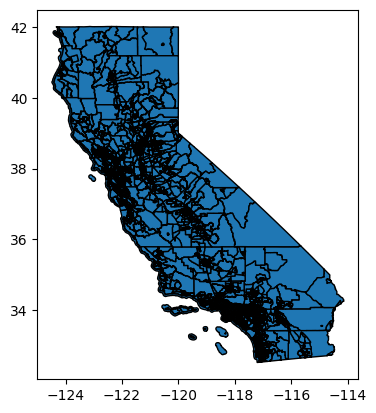

In [97]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,46005956900,"POLYGON ((-98.22734 44.36567, -98.22683 44.365..."
1,46005956700,"POLYGON ((-98.70576 44.63416, -98.70571 44.634..."
2,46005956800,"POLYGON ((-98.33633 44.3996, -98.33632 44.4022..."
3,46005957100,"POLYGON ((-98.21417 44.34231, -98.21417 44.342..."
4,46005956600,"POLYGON ((-98.33613 44.32718, -98.33403 44.327..."
...,...,...
237,46103010904,"POLYGON ((-103.22752 44.05663, -103.22751 44.0..."
238,46103010907,"POLYGON ((-103.19516 44.06749, -103.19493 44.0..."
239,46117960100,"POLYGON ((-101.16705 44.20464, -101.16684 44.2..."
240,46085972600,"POLYGON ((-100.36725 44.19462, -100.34714 44.1..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,46005956900,"POLYGON ((-98.227337 44.365671, -98.226829 44...."
1,46005956700,"POLYGON ((-98.705762 44.634159, -98.705712 44...."
2,46005956800,"POLYGON ((-98.336329 44.399599, -98.336319 44...."
3,46005957100,"POLYGON ((-98.214167 44.34231, -98.214166 44.3..."
4,46005956600,"POLYGON ((-98.336133 44.32718, -98.334029 44.3..."
...,...,...
237,46103010904,"POLYGON ((-103.227518 44.05663, -103.227511 44..."
238,46103010907,"POLYGON ((-103.195158 44.067488, -103.194931 4..."
239,46117960100,"POLYGON ((-101.167048 44.204637, -101.166845 4..."
240,46085972600,"POLYGON ((-100.367247 44.194621, -100.347139 4..."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 12 (337 kB)


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
!pip -q install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, os

drive = build('drive', 'v3')

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_South Dakota.csv e estados/separated/checkins_South Dakota.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  46005956900  POLYGON ((-98.22734 44.36567, -98.22683 44.365...
1  46005956700  POLYGON ((-98.70576 44.63416, -98.70571 44.634...
2  46005956800  POLYGON ((-98.33633 44.3996, -98.33632 44.4022...
3  46005957100  POLYGON ((-98.21417 44.34231, -98.21417 44.342...
4  46005956600  POLYGON ((-98.33613 44.32718, -98.33403 44.327...
           GEOID                                           geometry
0    46005956900  POLYGON ((-98.22734 44.36567, -98.22683 44.365...
1    46005956700  POLYGON ((-98.70576 44.63416, -98.70571 44.634...
2    46005956800  POLYGON ((-98.33633 44.3996, -98.33632 44.4022...
3    46005957100  POLYGON ((-98.21417 44.34231, -98.21417 44.342...
4    46005956600  POLYGON ((-98.33613 44.32718, -98.33403 44.327...
..           ...                                                ...
237  46103010904  POLYGON ((-103.22752 44.05663, -103.22751 44.0...
238  46103010907  POLYG

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0     211  0.200305
1          0     324  0.496053
2          0     230  0.517801
3          0     143  0.483614
4          0     747  0.397838
...      ...     ...       ...
2942     961     964  0.585007
2943     961     962  0.642352
2944     962     964  0.583682
2945     962     963  0.672320
2946     971     983  0.477099

[2947 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0     211  0.200305
1          0     324  0.496053
2          0     230  0.517801
3          0     143  0.483614
4          0     747  0.397838
...      ...     ...       ...
2942     961     964  0.585007
2943     961     962  0.642352
2944     962     964  0.583682
2945     962     963  0.672320
2946     971     983  0.477099

[2947 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data
reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency
creating region similarity by cosine similarity of embeddings
finishing preprocessing


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 3 islands with ids: 32, 39, 147.
  return W(neighbors, **kwargs)
/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 157
R area    : 157
R adj     : 157
R sim     : 157


In [ ]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Start training region embeddings for the city of gowalla
  0% 0/300 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 74, in <module>
    loss = train(epoch)
           ^^^^^^^^^^^^
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 60, in train
    pos_poi_emb_list, neg_poi_emb_list, region_emb, neg_region_emb, city_emb = model(data)
                                                                               ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwar

# Montana


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-montana-census-tracts

In [98]:
ESTADO = "Montana"

In [99]:
baixar_shapefile_estado("montana")

<Axes: >

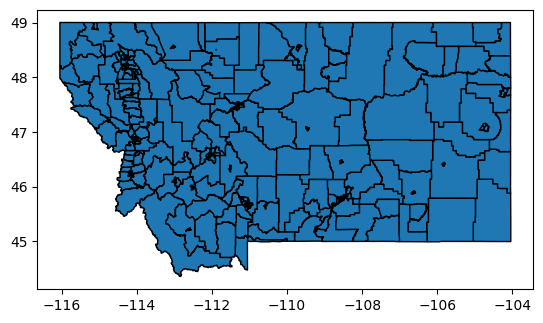

In [100]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [101]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,30111001300,"POLYGON ((-108.60195 45.80163, -108.60192 45.8..."
1,30111001702,"POLYGON ((-108.57625 45.77692, -108.57613 45.7..."
2,30111000704,"POLYGON ((-108.5707 45.82331, -108.57063 45.82..."
3,30111000902,"POLYGON ((-108.52542 45.76976, -108.5245 45.76..."
4,30111000200,"POLYGON ((-108.53398 45.80169, -108.53199 45.8..."
...,...,...
314,30087940400,"POLYGON ((-106.72961 45.40753, -106.72961 45.4..."
315,30087000300,"POLYGON ((-106.69316 45.87987, -106.69258 45.8..."
316,30087000200,"POLYGON ((-107.00756 46.30764, -107.00563 46.3..."
317,30087000100,"POLYGON ((-107.89762 46.8486, -107.89743 46.84..."


In [102]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [103]:
boroughs

,GEOID,geometry
0,30111001300,"POLYGON ((-108.601947 45.801632, -108.601919 4..."
1,30111001702,"POLYGON ((-108.576247 45.776925, -108.576126 4..."
2,30111000704,"POLYGON ((-108.570705 45.823311, -108.570632 4..."
3,30111000902,"POLYGON ((-108.525422 45.769761, -108.524497 4..."
4,30111000200,"POLYGON ((-108.53398 45.801689, -108.531994 45..."
...,...,...
314,30087940400,"POLYGON ((-106.729614 45.407528, -106.729612 4..."
315,30087000300,"POLYGON ((-106.693155 45.879866, -106.692576 4..."
316,30087000200,"POLYGON ((-107.007558 46.307645, -107.005634 4..."
317,30087000100,"POLYGON ((-107.897619 46.848602, -107.897429 4..."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 12 (337 kB)


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
!pip -q install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, os

drive = build('drive', 'v3')

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_South Dakota.csv e estados/separated/checkins_South Dakota.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  46005956900  POLYGON ((-98.22734 44.36567, -98.22683 44.365...
1  46005956700  POLYGON ((-98.70576 44.63416, -98.70571 44.634...
2  46005956800  POLYGON ((-98.33633 44.3996, -98.33632 44.4022...
3  46005957100  POLYGON ((-98.21417 44.34231, -98.21417 44.342...
4  46005956600  POLYGON ((-98.33613 44.32718, -98.33403 44.327...
           GEOID                                           geometry
0    46005956900  POLYGON ((-98.22734 44.36567, -98.22683 44.365...
1    46005956700  POLYGON ((-98.70576 44.63416, -98.70571 44.634...
2    46005956800  POLYGON ((-98.33633 44.3996, -98.33632 44.4022...
3    46005957100  POLYGON ((-98.21417 44.34231, -98.21417 44.342...
4    46005956600  POLYGON ((-98.33613 44.32718, -98.33403 44.327...
..           ...                                                ...
237  46103010904  POLYGON ((-103.22752 44.05663, -103.22751 44.0...
238  46103010907  POLYG

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0     211  0.200305
1          0     324  0.496053
2          0     230  0.517801
3          0     143  0.483614
4          0     747  0.397838
...      ...     ...       ...
2942     961     964  0.585007
2943     961     962  0.642352
2944     962     964  0.583682
2945     962     963  0.672320
2946     971     983  0.477099

[2947 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0     211  0.200305
1          0     324  0.496053
2          0     230  0.517801
3          0     143  0.483614
4          0     747  0.397838
...      ...     ...       ...
2942     961     964  0.585007
2943     961     962  0.642352
2944     962     964  0.583682
2945     962     963  0.672320
2946     971     983  0.477099

[2947 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data
reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency
creating region similarity by cosine similarity of embeddings
finishing preprocessing


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 3 islands with ids: 32, 39, 147.
  return W(neighbors, **kwargs)
/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 157
R area    : 157
R adj     : 157
R sim     : 157


In [ ]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Start training region embeddings for the city of gowalla
  0% 0/300 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 74, in <module>
    loss = train(epoch)
           ^^^^^^^^^^^^
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 60, in train
    pos_poi_emb_list, neg_poi_emb_list, region_emb, neg_region_emb, city_emb = model(data)
                                                                               ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwar

# Alabama


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-alabama-census-tracts

In [75]:
ESTADO = "Alabama"

In [78]:
baixar_shapefile_estado("alabama")

<Axes: >

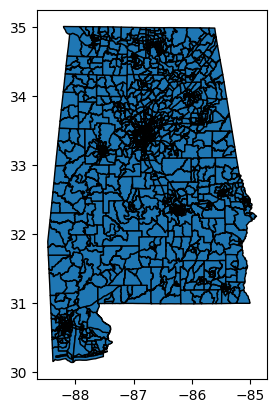

In [79]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [80]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,01079979201,"POLYGON ((-87.43611 34.72743, -87.4361 34.7274..."
1,01079979202,"POLYGON ((-87.45696 34.61352, -87.45693 34.613..."
2,01079979502,"POLYGON ((-87.29614 34.54337, -87.2961 34.5434..."
3,01079979501,"POLYGON ((-87.20741 34.5571, -87.2074 34.55731..."
4,01009050103,"POLYGON ((-86.57229 33.8207, -86.57229 33.8208..."
...,...,...
1432,01087232200,"POLYGON ((-86.02316 32.41927, -86.02312 32.419..."
1433,01087232000,"POLYGON ((-85.71336 32.44663, -85.71318 32.447..."
1434,01087231500,"POLYGON ((-85.88615 32.49305, -85.88575 32.493..."
1435,01087231400,"POLYGON ((-85.64797 32.44458, -85.64626 32.445..."


In [81]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [82]:
boroughs

,GEOID,geometry
0,01079979201,"POLYGON ((-87.436107 34.727427, -87.436104 34...."
1,01079979202,"POLYGON ((-87.45696 34.613518, -87.456933 34.6..."
2,01079979502,"POLYGON ((-87.296137 34.543373, -87.296104 34...."
3,01079979501,"POLYGON ((-87.20741 34.557097, -87.2074 34.557..."
4,01009050103,"POLYGON ((-86.572293 33.820705, -86.572291 33...."
...,...,...
1432,01087232200,"POLYGON ((-86.023164 32.419268, -86.02312 32.4..."
1433,01087232000,"POLYGON ((-85.713356 32.446634, -85.713179 32...."
1434,01087231500,"POLYGON ((-85.886148 32.493053, -85.885746 32...."
1435,01087231400,"POLYGON ((-85.647973 32.444578, -85.64626 32.4..."


In [8]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 6 (250 kB)


In [9]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [10]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [83]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

[Errno 2] No such file or directory: 'drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main'
/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [84]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_Alabama.csv e estados/separated/checkins_Alabama.csv


In [85]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [86]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [87]:


from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
        GEOID                                           geometry
0  1079979201  POLYGON ((-87.43611 34.72743, -87.4361 34.7274...
1  1079979202  POLYGON ((-87.45696 34.61352, -87.45693 34.613...
2  1079979502  POLYGON ((-87.29614 34.54337, -87.2961 34.5434...
3  1079979501  POLYGON ((-87.20741 34.5571, -87.2074 34.55731...
4  1009050103  POLYGON ((-86.57229 33.8207, -86.57229 33.8208...
           GEOID                                           geometry
0     1079979201  POLYGON ((-87.43611 34.72743, -87.4361 34.7274...
1     1079979202  POLYGON ((-87.45696 34.61352, -87.45693 34.613...
2     1079979502  POLYGON ((-87.29614 34.54337, -87.2961 34.5434...
3     1079979501  POLYGON ((-87.20741 34.5571, -87.2074 34.55731...
4     1009050103  POLYGON ((-86.57229 33.8207, -86.57229 33.8208...
...          ...                                                ...
1432  1087232200  POLYGON ((-86.02316 32.41927, -86.02312 32.419...
1433  1087232000  POLYGON ((-

In [88]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


       source  target    weight
0           0    9801  0.489154
1           0    9537  0.489154
2           0    9591  0.576713
3           0    3260  0.587017
4           0    4845  0.566219
...       ...     ...       ...
30777   10238   10239  0.631456
30778   10238   10240  0.414344
30779   10239   10242  0.451068
30780   10239   10240  0.421236
30781   10255   10259  0.386090

[30782 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [89]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


       source  target    weight
0           0    9801  0.489154
1           0    9537  0.489154
2           0    9591  0.576713
3           0    3260  0.587017
4           0    4845  0.566219
...       ...     ...       ...
30777   10238   10239  0.631456
30778   10238   10240  0.414344
30779   10239   10242  0.451068
30780   10239   10240  0.421236
30781   10255   10259  0.386090

[30782 rows x 3 columns]


## HGI

In [90]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [91]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 7 islands with ids: 131, 288, 310, 775, 863, 865, 1065.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency


/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

creating region similarity by cosine similarity of embeddings
finishing preprocessing


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 7 islands with ids: 131, 288, 310, 775, 863, 865, 1065.
  return W(neighbors, **kwargs)


In [92]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [93]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 1072
R area    : 1072
R adj     : 1072
R sim     : 1072


In [94]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Start training region embeddings for the city of gowalla
  0% 0/300 [00:00<?, ?it/s]Parameter containing:
tensor([[ 0.1234, -0.0977,  0.0565,  ..., -0.0098,  0.0997, -0.0469],
        [-0.0819,  0.0133,  0.0604,  ...,  0.0867, -0.0024,  0.0767],
        [-0.0160,  0.0734,  0.0274,  ..., -0.0407,  0.0581,  0.1094],
        ...,
        [-0.0384,  0.0289,  0.0081,  ...,  0.0892,  0.1014, -0.0917],
        [ 0.0105, -0.0858,  0.0184,  ...,  0.0918,  0.0682, -0.0590],
        [ 0.0179, -0.0920,  0.0692,  ..., -0.0179,  0.0965, -0.0882]],
       requires_grad=True) Parameter containing:
tensor([[ 0.0862,  0.1164,  0.1037,  ...,  0.0429,  0.0697,  0.0563],
        [ 0.1082, -0.0978, -0.0370,  ..., -0.0539, -0.0608, -0.0783],
        [-0.0809,  0.0773, -0.0612,  ..., -0.1044,  0.0694,  0.0892],
        ...,
        [ 0.0828,  0.0516,  0.0781,  ..., -0.0906,  0.1187, -0.0582],
        [-0.0515,  0.0034, -0.1073,  ...,  0.0085, -0.0066,  0.0797],
        [ 0.0142,  0.1144, -0.0443,  ...,  0.033

# South Dakota (fins de teste)


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-south-dakota-census-tracts

In [60]:
ESTADO = "South Dakota"

In [61]:
baixar_shapefile_estado("south-dakota")

<Axes: >

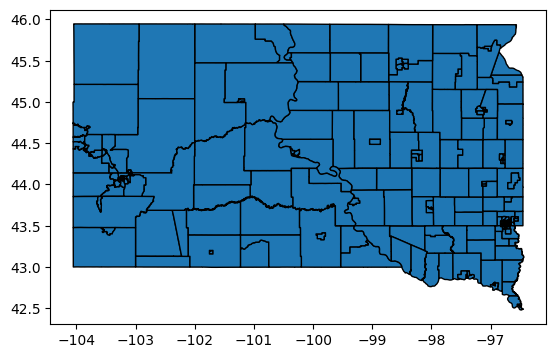

In [62]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [63]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,46005956900,"POLYGON ((-98.22734 44.36567, -98.22683 44.365..."
1,46005956700,"POLYGON ((-98.70576 44.63416, -98.70571 44.634..."
2,46005956800,"POLYGON ((-98.33633 44.3996, -98.33632 44.4022..."
3,46005957100,"POLYGON ((-98.21417 44.34231, -98.21417 44.342..."
4,46005956600,"POLYGON ((-98.33613 44.32718, -98.33403 44.327..."
...,...,...
237,46103010904,"POLYGON ((-103.22752 44.05663, -103.22751 44.0..."
238,46103010907,"POLYGON ((-103.19516 44.06749, -103.19493 44.0..."
239,46117960100,"POLYGON ((-101.16705 44.20464, -101.16684 44.2..."
240,46085972600,"POLYGON ((-100.36725 44.19462, -100.34714 44.1..."


In [64]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [65]:
boroughs

,GEOID,geometry
0,46005956900,"POLYGON ((-98.227337 44.365671, -98.226829 44...."
1,46005956700,"POLYGON ((-98.705762 44.634159, -98.705712 44...."
2,46005956800,"POLYGON ((-98.336329 44.399599, -98.336319 44...."
3,46005957100,"POLYGON ((-98.214167 44.34231, -98.214166 44.3..."
4,46005956600,"POLYGON ((-98.336133 44.32718, -98.334029 44.3..."
...,...,...
237,46103010904,"POLYGON ((-103.227518 44.05663, -103.227511 44..."
238,46103010907,"POLYGON ((-103.195158 44.067488, -103.194931 4..."
239,46117960100,"POLYGON ((-101.167048 44.204637, -101.166845 4..."
240,46085972600,"POLYGON ((-100.367247 44.194621, -100.347139 4..."


In [49]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 12 (337 kB)


In [50]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [51]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [12]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
!pip -q install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, os

drive = build('drive', 'v3')

In [52]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_South Dakota.csv e estados/separated/checkins_South Dakota.csv


In [53]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [66]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [67]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  46005956900  POLYGON ((-98.22734 44.36567, -98.22683 44.365...
1  46005956700  POLYGON ((-98.70576 44.63416, -98.70571 44.634...
2  46005956800  POLYGON ((-98.33633 44.3996, -98.33632 44.4022...
3  46005957100  POLYGON ((-98.21417 44.34231, -98.21417 44.342...
4  46005956600  POLYGON ((-98.33613 44.32718, -98.33403 44.327...
           GEOID                                           geometry
0    46005956900  POLYGON ((-98.22734 44.36567, -98.22683 44.365...
1    46005956700  POLYGON ((-98.70576 44.63416, -98.70571 44.634...
2    46005956800  POLYGON ((-98.33633 44.3996, -98.33632 44.4022...
3    46005957100  POLYGON ((-98.21417 44.34231, -98.21417 44.342...
4    46005956600  POLYGON ((-98.33613 44.32718, -98.33403 44.327...
..           ...                                                ...
237  46103010904  POLYGON ((-103.22752 44.05663, -103.22751 44.0...
238  46103010907  POLYG

In [68]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0     211  0.200305
1          0     324  0.496053
2          0     230  0.517801
3          0     143  0.483614
4          0     747  0.397838
...      ...     ...       ...
2942     961     964  0.585007
2943     961     962  0.642352
2944     962     964  0.583682
2945     962     963  0.672320
2946     971     983  0.477099

[2947 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [69]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0     211  0.200305
1          0     324  0.496053
2          0     230  0.517801
3          0     143  0.483614
4          0     747  0.397838
...      ...     ...       ...
2942     961     964  0.585007
2943     961     962  0.642352
2944     962     964  0.583682
2945     962     963  0.672320
2946     971     983  0.477099

[2947 rows x 3 columns]


## HGI

In [70]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [71]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data
reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency
creating region similarity by cosine similarity of embeddings
finishing preprocessing


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 3 islands with ids: 32, 39, 147.
  return W(neighbors, **kwargs)
/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

In [72]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [73]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 157
R area    : 157
R adj     : 157
R sim     : 157


In [74]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Start training region embeddings for the city of gowalla
  0% 0/300 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 74, in <module>
    loss = train(epoch)
           ^^^^^^^^^^^^
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 60, in train
    pos_poi_emb_list, neg_poi_emb_list, region_emb, neg_region_emb, city_emb = model(data)
                                                                               ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwar